In [38]:
from utils.download_kaggle_dataset import download_kaggle_competition
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [10]:
data = download_kaggle_competition("nflx-stock-price-prediction")
df = pd.read_csv(f"{data}/HistoricalData_1744405684704.csv")

Unzipping files...
Competition data downloaded to: datasets


In [11]:
print(df.head())

print(df.isnull().sum())

print(df.info())

print(df.describe())


         Date Close/Last   Volume      Open       High      Low
0  04/10/2025    $921.17  5129755   $931.94   $941.235  $894.00
1  04/09/2025    $945.47  7497974   $855.93    $951.43  $854.40
2  04/08/2025    $870.40  5625382   $912.44    $922.42  $857.70
3  04/07/2025    $867.83  6656823  $827.845    $906.74  $821.10
4  04/04/2025    $855.86  6798806   $896.50  $906.6282  $853.87
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB
None
             Volume
coun

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

df.sort_index(inplace=True)


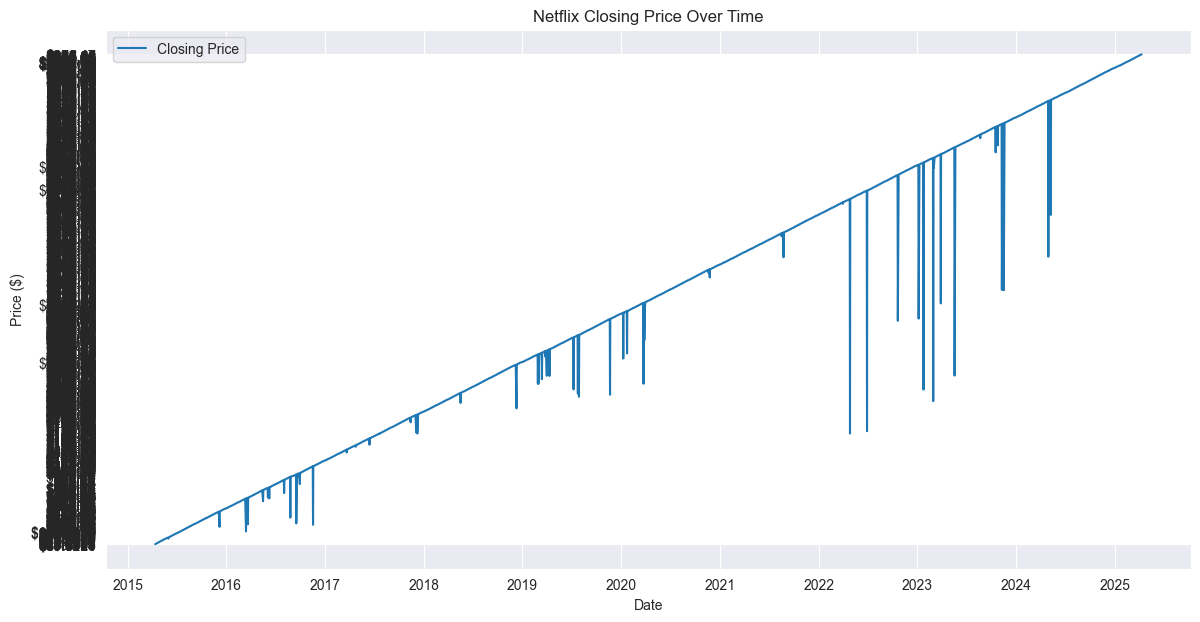

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'], label='Closing Price')
plt.title('Netflix Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


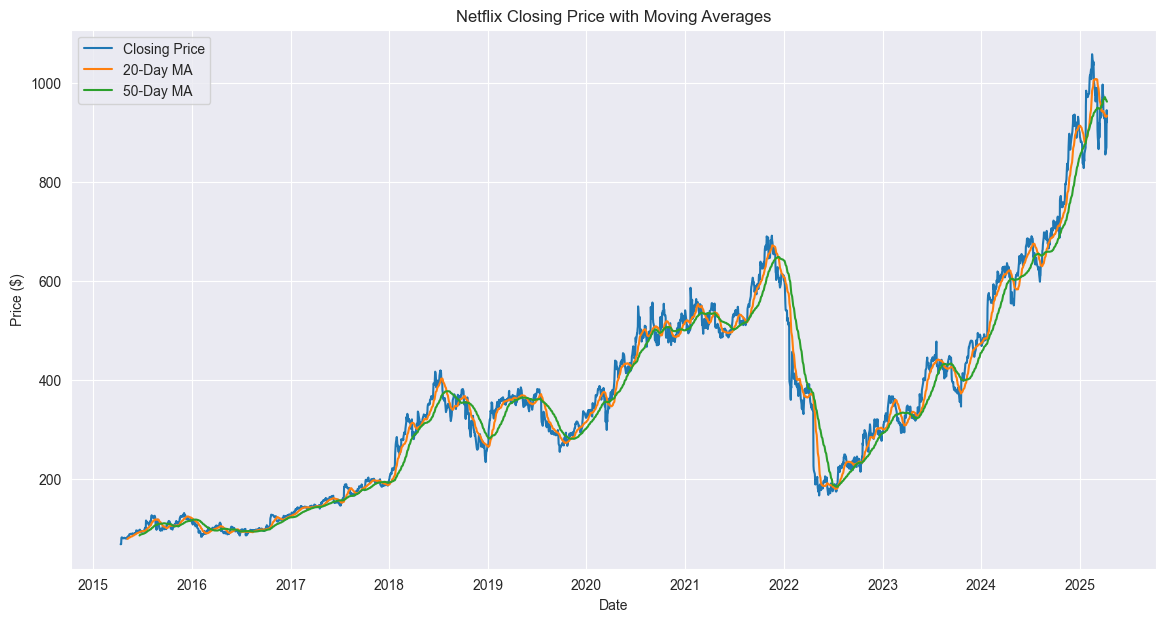

In [17]:
df['Close/Last'] = df['Close/Last'].replace('[\$,]', '', regex=True).astype(float)

df['MA20'] = df['Close/Last'].rolling(window=20).mean()
df['MA50'] = df['Close/Last'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Close/Last'], label='Closing Price')
plt.plot(df['MA20'], label='20-Day MA')
plt.plot(df['MA50'], label='50-Day MA')
plt.title('Netflix Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


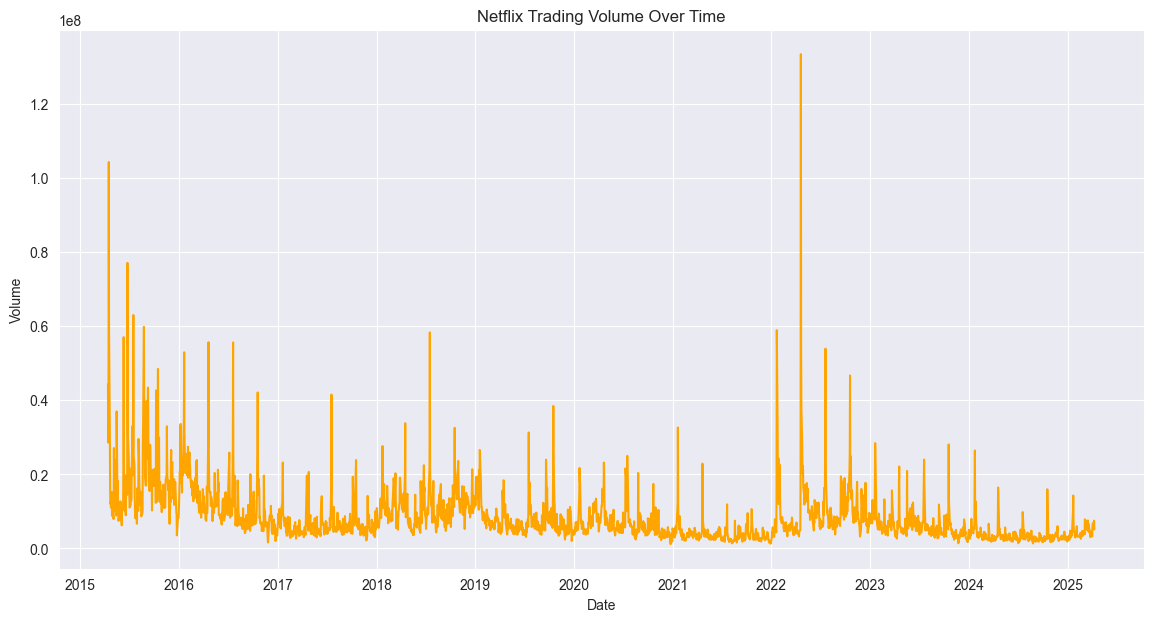

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(df['Volume'], color='orange')
plt.title('Netflix Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


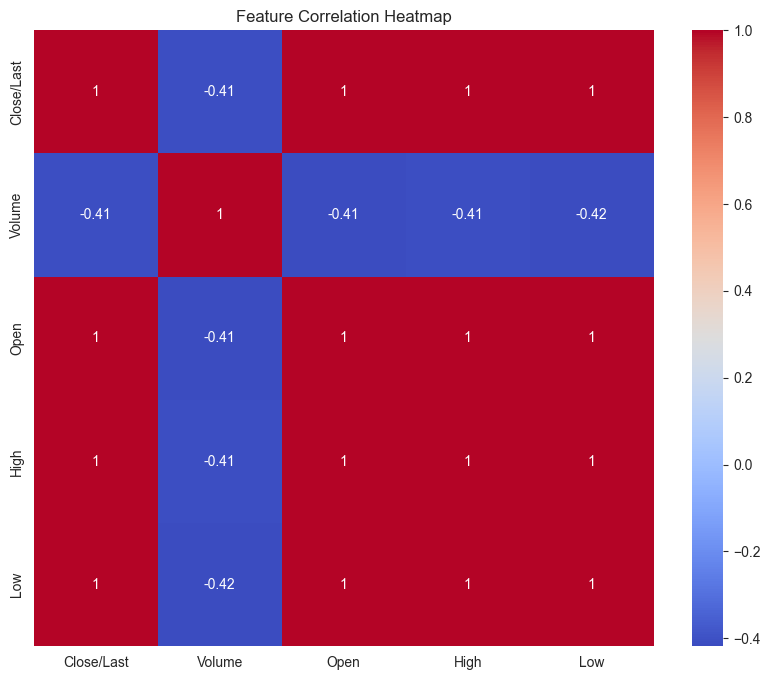

In [25]:
uncleaned = ['Close/Last', 'Volume', 'Open', 'High', 'Low']
clean_df =  df[uncleaned].replace('[\$,]', '', regex=True).astype(float)
corr = clean_df[['Close/Last','Volume','Open','High','Low']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


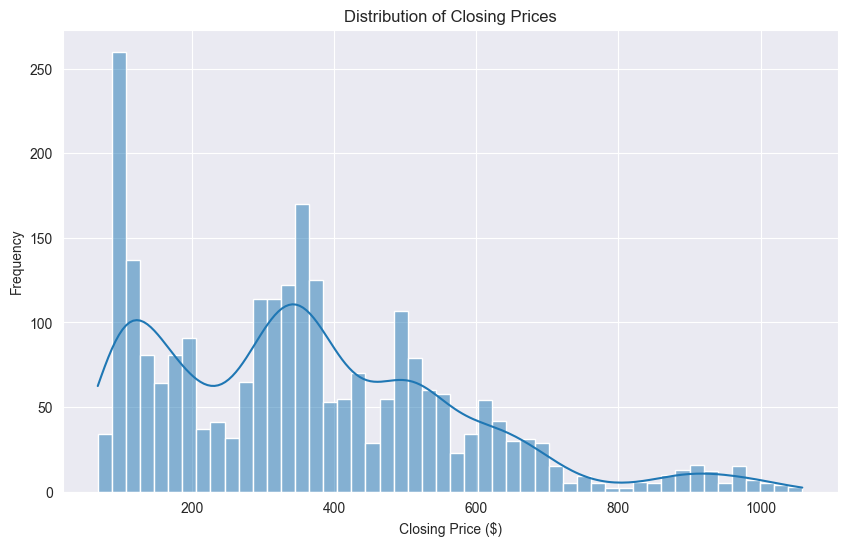

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Close/Last'], bins=50, kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price ($)')
plt.ylabel('Frequency')
plt.show()


/var/folders/fd/lyppdp1x5nj0j4jp1m6ww18r0000gn/T/ipykernel_5038/3275582521.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df['Close/Last'].resample('M').mean()


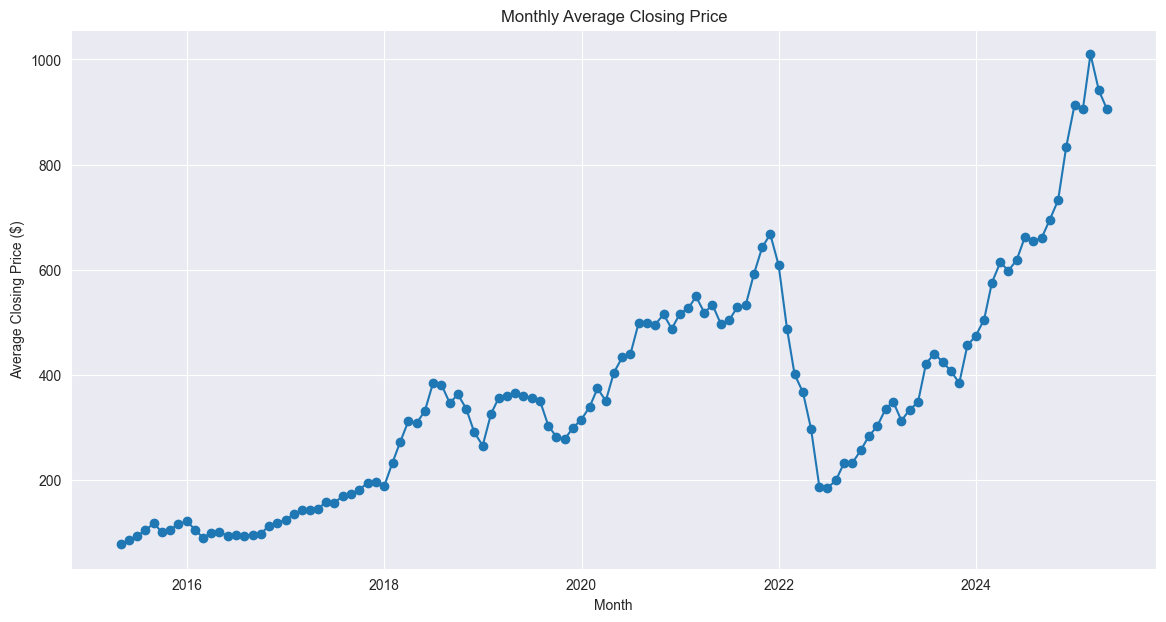

In [31]:
monthly_avg = df['Close/Last'].resample('M').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg, marker='o')
plt.title('Monthly Average Closing Price')
plt.xlabel('Month')
plt.ylabel('Average Closing Price ($)')
plt.show()


In [33]:
df['Close/Last'] = df['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
df['Open'] = df['Open'].replace('[\$,]', '', regex=True).astype(float)
df['High'] = df['High'].replace('[\$,]', '', regex=True).astype(float)
df['Low'] = df['Low'].replace('[\$,]', '', regex=True).astype(float)

df.sort_values('Date', inplace=True)
df['MA10'] = df['Close/Last'].rolling(window=10).mean()
df['MA20'] = df['Close/Last'].rolling(window=20).mean()
df['STD20'] = df['Close/Last'].rolling(window=20).std()
df['Return'] = df['Close/Last'].pct_change()
df['Volume'] = df['Volume'].replace(',', '', regex=True).astype(float)
df = df.dropna()

In [37]:
features = ['Open', 'High', 'Low', 'MA10', 'MA20', 'STD20', 'Return', 'Volume']
target = 'Close/Last'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [39]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results.append((name, rmse, mae, r2))

results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2 Score'])
print(results_df.sort_values('RMSE'))

/Users/navin/Documents/Anik/GitHub/kaggle-playground/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.59544e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/navin/Documents/Anik/GitHub/kaggle-playground/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+04, tolerance: 4.719e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1973, number of used features: 8
[LightGBM] [Info] Start training from score 301.815213
               Model        RMSE        MAE  R2 Score
0  Linear Regression    4.427689   3.136690  0.999484
1              Ridge    4.486619   3.219448  0.999470
2              Lasso    7.585314   5.321963  0.998486
4  Gradient Boosting  114.589894  56.900327  0.654470
5            XGBoost  114.790227  57.298346  0.653261
3      Random Forest  115.146741  56.947458  0.651104
6           LightGBM  119.672294  59.943345  0.623140


/Users/navin/Documents/Anik/GitHub/kaggle-playground/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RMSE: 6.7351
MAE: 4.6319
R²: 0.9988


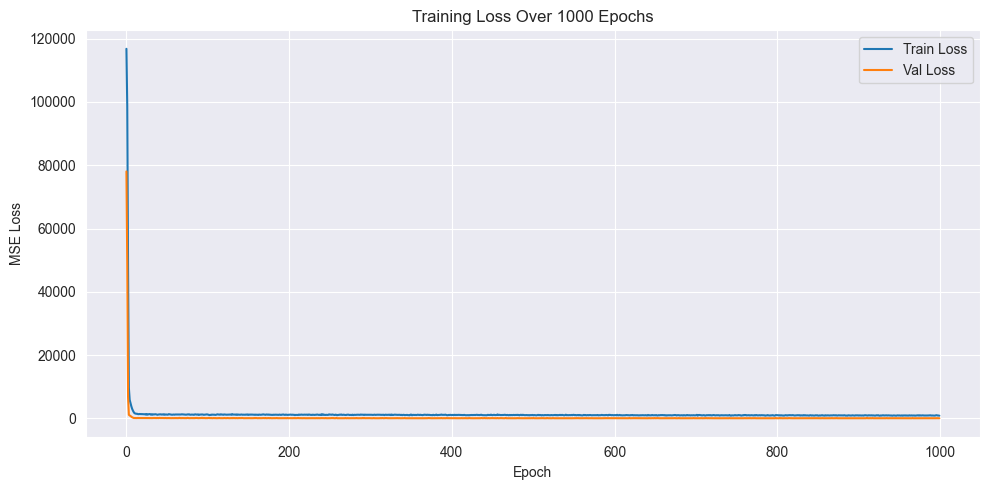

In [41]:
features = ['Open', 'High', 'Low', 'Volume', 'MA10', 'MA20', 'STD20', 'Return']
target = 'Close/Last'

X = df[features]
y = df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build neural network
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train model for 1000 epochs
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.1, verbose=0)

# Evaluate
y_pred = model.predict(X_test).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training Loss Over 1000 Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()